## University of Washington | DATA 512 - Human Centered Data Science | Autumn 2020

### Assignment 2: Bias in Data

--------------------

### Summary

The objective of this assignment is to examine the potential sources of bias in a corpus of human-annotated data and describe some implications of those biases.

### Data Source

The data we use in this assignment is "Wikipedia Talk Labels" which you can download from this Figshare page:
https://figshare.com/projects/Wikipedia_Talk/16731

There are three separate datasets:
- Toxicity
- Aggression
- Personal Attacks

Each individual dataset contains three separate TSV files: annotations, annotated comments, and worker demographics. You can download these datasets and store on your project working directory.

### Motivation for the analysis

Social bias online has been gaining steam in the last five years. The more interaction users perform online, the larger data it produces with comments include toxicity and aggression. Therefore,  i am interested in knowing more about the bias in these two areas: toxicity and aggression.

There are two hypothesis/questions that i want to find out:
- Is there a bias relationships between worker demographics and labeling behavior in toxicity?
- Is there a bias relationships between worker demographics and labeling behavior in aggression?


-----------------------------------------------

# Part 1: Exploratory Data Analysis (EDA)

Import the libraries from Python

In [1]:
import csv
import pandas as pd
import numpy as np
import seaborn as sn
import matplotlib.pyplot as plt

## Analysis: Toxicity Dataset

### Get Data & Clean Up

Get Toxicity data files into data frames. For code simplification, we use annotation as follow:

- ann = annotations
- com = annotated comments
- dem = worker demographics

In [2]:
df_toxicity_ann = pd.read_csv('toxicity_annotations.tsv', sep = '\t')

df_toxicity_com = pd.read_csv('toxicity_annotated_comments.tsv', sep = '\t')

df_toxicity_dem = pd.read_csv('toxicity_worker_demographics.tsv', sep = '\t')

Perform visual inspection of the data

In [3]:
df_toxicity_ann.head()

,rev_id,worker_id,toxicity,toxicity_score
0,2232.0,723,0,0.0
1,2232.0,4000,0,0.0
2,2232.0,3989,0,1.0
3,2232.0,3341,0,0.0
4,2232.0,1574,0,1.0


In [4]:
df_toxicity_com.head()

,rev_id,comment,year,logged_in,ns,sample,split
0,2232.0,This:NEWLINE_TOKEN:One can make an analogy in ...,2002,True,article,random,train
1,4216.0,`NEWLINE_TOKENNEWLINE_TOKEN:Clarification for ...,2002,True,user,random,train
2,8953.0,Elected or Electoral? JHK,2002,False,article,random,test
3,26547.0,`This is such a fun entry. DevotchkaNEWLINE_...,2002,True,article,random,train
4,28959.0,Please relate the ozone hole to increases in c...,2002,True,article,random,test


In [5]:
df_toxicity_dem.head()

,worker_id,gender,english_first_language,age_group,education
0,85,female,0,18-30,bachelors
1,1617,female,0,45-60,bachelors
2,1394,female,0,NaN,bachelors
3,311,male,0,30-45,bachelors
4,1980,male,0,45-60,masters


From observation, we see there are some data cleanning we need to do in order to have a clean data.

In [6]:
# Reformat the numeric values to remove the ".0"
df_toxicity_ann = df_toxicity_ann.astype(int)

# Reformat the numeric values to remove the ".0"
df_toxicity_com['rev_id'] = df_toxicity_com['rev_id'].astype(int)

# remove newline and tab tokens
df_toxicity_com['comment'] = df_toxicity_com['comment'].apply(lambda x: x.replace("NEWLINE_TOKEN", " "))
df_toxicity_com['comment'] = df_toxicity_com['comment'].apply(lambda x: x.replace("TAB_TOKEN", " "))

### Descriptive Statistics Checking

Checking total of unique records of three data files

In [7]:
print("Total annotations: ", len(df_toxicity_ann['rev_id'].unique()))
print("Total annotated comments: ", len(df_toxicity_com['rev_id'].unique()))
print("Total workers: ", len(df_toxicity_dem['worker_id'].unique()))

Total annotations:  159686
Total annotated comments:  159686
Total workers:  3591


Since we are interested in question about demograpic, let's do a brief glance through key demographic data components

**Gender distribution**

In [8]:
# Distribution table
df_toxicity_dem['gender'].value_counts()

male      2327
female    1263
other        1
Name: gender, dtype: int64

*Comment 1: There is one worker does not identify as either male or female. This one "other" is  not significant in a whole schema and is a noise. So we need to remove it from the data frame*

In [9]:
# Remove this one record for this unique worker
df_toxicity_dem = df_toxicity_dem.drop(df_toxicity_dem[df_toxicity_dem.gender == 'other'].index)

# Review the clean gender data
df_toxicity_dem['gender'].value_counts()

male      2327
female    1263
Name: gender, dtype: int64

Let's look at the frequency table

In [10]:
# Frequency table
x1 = df_toxicity_dem['gender'].value_counts()
x1 / x1.sum()

male      0.648189
female    0.351811
Name: gender, dtype: float64

*Comment 2: There are about **2X** number of male workers than female workers. Male workers account **64.8%**. This means the gender is not balanced among the workers. This factor shows a **BIAS** in annotating the toxicity comment because men and women have different perspective about toxicity.*

**English first language distribution**

In [11]:
# Distribution table
df_toxicity_dem['english_first_language'].value_counts()

0    2924
1     666
Name: english_first_language, dtype: int64

Let's look at the frequency table

In [12]:
# Frequency table
x2 = df_toxicity_dem['english_first_language'].value_counts()
x2 / x2.sum()

0    0.814485
1    0.185515
Name: english_first_language, dtype: float64

*Comment 3: The number of workers that don't have English as first language is about **4.4X** time more than the workers with English as first language (accounts **81.4%**). This is an important notice to mention in the analysis, this factor shows a **BIAS** because it impacts the judgement of worker to label the English comment as toxic or non-toxic*

**Age group distribution**

In [13]:
# Distribution table
df_toxicity_dem['age_group'].value_counts()

18-30       1862
30-45       1247
45-60        296
Under 18      78
Over 60       30
Name: age_group, dtype: int64

Let's look at the frequency table

In [14]:
# Frequency table
x3 = df_toxicity_dem['age_group'].value_counts()
x3 / x3.sum()

18-30       0.530031
30-45       0.354967
45-60       0.084258
Under 18    0.022203
Over 60     0.008540
Name: age_group, dtype: float64

*Comment 4: The age distribution of the workers who labelled the toxicity dataset shows that the vast majority of the data was labelled by people ages 18 - 45 which account **88%**. This is **BIAS** because the distribution is not equal across the age groups. We can see less representation for people who are older and younger than 45 and 18 respectively. Whether this is millenium generation, baby boom generation, generation X, etc. they each have different lived experiences which could affect their decision in what constitutes a toxic comment.*

**Education distribution**

In [15]:
# Distribution table
df_toxicity_dem['education'].value_counts()

bachelors       1441
hs              1025
masters          546
professional     441
some              93
doctorate         41
none               3
Name: education, dtype: int64

Let's look at the frequency table

In [16]:
# Frequency table
x4 = df_toxicity_dem['education'].value_counts()
x4 / x4.sum()

bachelors       0.401393
hs              0.285515
masters         0.152089
professional    0.122841
some            0.025905
doctorate       0.011421
none            0.000836
Name: education, dtype: float64

*Comment 5: We can see from the distribution that the higher education (bachelors + masters + doctorate = **56.5%**) which is more than half of the total worker education background. This is **BIAS** because different education background would impact the critical thinking and educational judgement on if the comment is toxic or not in this nature.*

### MERGE DATA: demographic data + toxicity data

Three separate data files are not helpful to unlock an insights. Therefore, we will merge all three data files into one final data frame. This will help us to see the relationship between data componnents

In [17]:
# Merge the data frame of toxicity annotation and demographic worker
df_toxicity_ann_dem = pd.merge(df_toxicity_ann, df_toxicity_dem, on = 'worker_id', how = 'outer')

# Merge the result with the comment data frame
df_toxicity_final = pd.merge(df_toxicity_ann_dem, df_toxicity_com, on = 'rev_id', how = 'outer')

Viewing final data

In [18]:
df_toxicity_final.head()

,rev_id,worker_id,toxicity,toxicity_score,gender,english_first_language,age_group,education,comment,year,logged_in,ns,sample,split
0,2232,723,0,0,female,0.0,30-45,bachelors,This: :One can make an analogy in mathematical...,2002,True,article,random,train
1,2232,4000,0,0,male,1.0,18-30,hs,This: :One can make an analogy in mathematical...,2002,True,article,random,train
2,2232,3989,0,1,female,0.0,18-30,bachelors,This: :One can make an analogy in mathematical...,2002,True,article,random,train
3,2232,3341,0,0,NaN,NaN,NaN,NaN,This: :One can make an analogy in mathematical...,2002,True,article,random,train
4,2232,1574,0,1,female,0.0,30-45,bachelors,This: :One can make an analogy in mathematical...,2002,True,article,random,train


From observation of dataset, there are some NaN values. Let's find out in the dataset about these NaN for these workers

In [19]:
# count the number of NaN value from the final dataset
toxicity_count_NaN = df_toxicity_final.isnull().sum()
toxicity_count_NaN

rev_id                         0
worker_id                      0
toxicity                       0
toxicity_score                 0
gender                    251692
english_first_language    251692
age_group                 281006
education                 251692
comment                        0
year                           0
logged_in                      0
ns                             0
sample                         0
split                          0
dtype: int64

*Comment 6: there are four places the NaN values show up in the merge dataset. Any data with NaN in the dataset won't be helpful and can create a distortion which impacts the data quality overall. We need to drop these NaN (not a number) from the data frame since it won't be helpful for the analysis*

In [20]:
# Drop rows with NaN values from the final data frame
df_toxicity_new_final = df_toxicity_final.dropna()
df_toxicity_new_final.head()

,rev_id,worker_id,toxicity,toxicity_score,gender,english_first_language,age_group,education,comment,year,logged_in,ns,sample,split
0,2232,723,0,0,female,0.0,30-45,bachelors,This: :One can make an analogy in mathematical...,2002,True,article,random,train
1,2232,4000,0,0,male,1.0,18-30,hs,This: :One can make an analogy in mathematical...,2002,True,article,random,train
2,2232,3989,0,1,female,0.0,18-30,bachelors,This: :One can make an analogy in mathematical...,2002,True,article,random,train
4,2232,1574,0,1,female,0.0,30-45,bachelors,This: :One can make an analogy in mathematical...,2002,True,article,random,train
5,2232,1508,0,1,female,1.0,45-60,hs,This: :One can make an analogy in mathematical...,2002,True,article,random,train


### EVALUATE: demographic data + toxicity data

Let's check the kernel density plot of toxicity score to see how it plays out

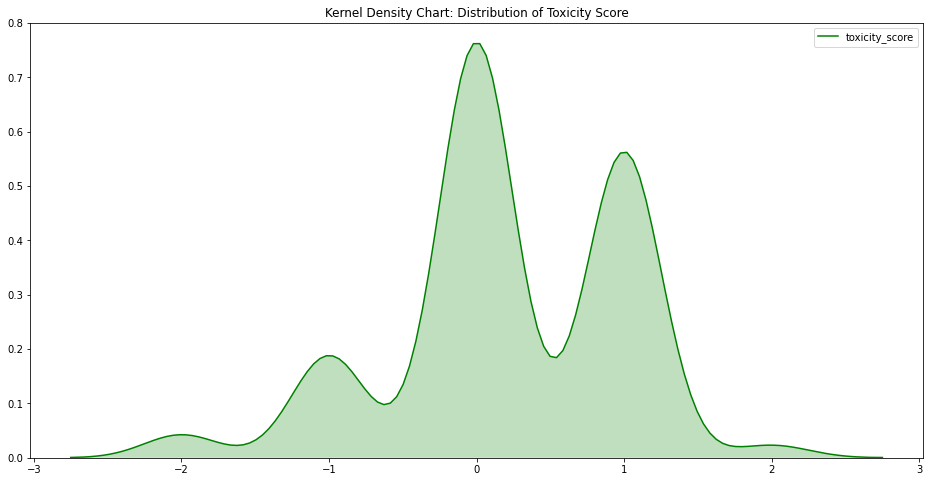

In [21]:
fig = plt.gcf()
fig.set_size_inches(16, 8)

# Kernel Density Plot
sn.kdeplot(df_toxicity_new_final['toxicity_score'], shade=True, color='g', 
           bw = 1/(np.max(df_toxicity_new_final['toxicity_score'])-np.min(df_toxicity_new_final['toxicity_score'])));

plt.title('Kernel Density Chart: Distribution of Toxicity Score')

# Save the plot into a JPG picture file. The file will be saved in the same working directory of my Jupyter notebook.
# The path location will be different on your machine. Feel free to update the directory to your choice.
plt.savefig('A2_chart_toxicity_score-kernel_density.jpg', bbox_inches='tight', dpi=80)

*Comment 7: Categorical variable ranging from very toxic (-2), to neutral (0), to very healthy (2)*

*From the kernel density plot, we see that majority of toxicity score are **neutral (0) and slightly healthy (1)** comment.*

*However, in order to get deeper into the insights to see potential bias, we need to see toxicity score with other data fields. Let's check the correlation to see if there are any useful information*

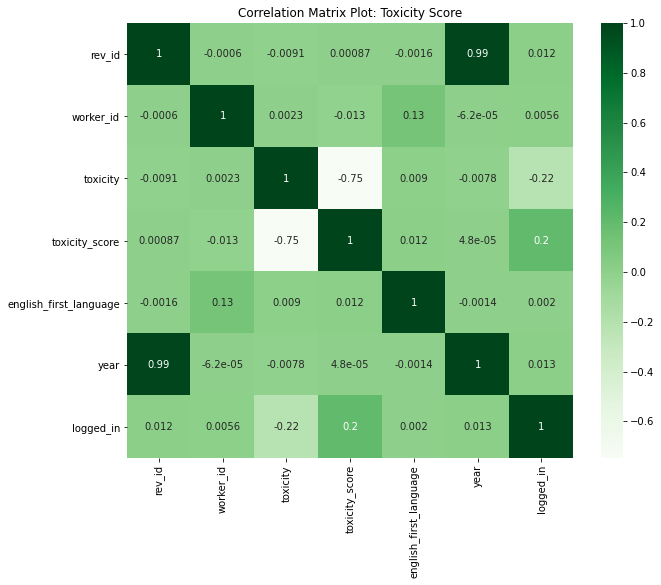

In [22]:
# Plot the correlation matrix
fig, ax = plt.subplots(figsize=(10,8))

corrMatrix_toxicity = df_toxicity_new_final.corr()

sn.heatmap(corrMatrix_toxicity, annot=True, cmap="Greens")

plt.title("Correlation Matrix Plot: Toxicity Score")

# Save the plot into a JPG picture file. The file will be saved in the same working directory of my Jupyter notebook.
# The path location will be different on your machine. Feel free to update the directory to your choice.
plt.savefig('A2_chart_toxicity_score-correlation_matrix.jpg', bbox_inches='tight', dpi=80)

plt.show()

*Comment 8: From the correlation matrix, we dont see any correlation among the **numeric data fields** that impacts the toxicity_score with more than 0.5* 

*This helps us to narrow down the scope and focus on the **categorical data fields** for bias with the following data fields: gender, age_group, and education*

**Evaluate: Gender + Toxicity Score**

Generate a pivot table between data fields and broken down gender into the toxicity score range

In [23]:
# Transform the data into pivot table format for detail analysis
toxicity_tab_gender = pd.crosstab(df_toxicity_new_final['gender'], 
                                  columns = df_toxicity_new_final['toxicity_score'])
toxicity_tab_gender

toxicity_score,-2,-1,0,1,2
gender,,,,,
female,13787,56300,217921,151632,6465
male,21564,100316,419032,317528,12738


In [24]:
# Viewing details from total distribution by toxicity score bucket
toxicity_tab_gender / toxicity_tab_gender.sum()

toxicity_score,-2,-1,0,1,2
gender,,,,,
female,0.390003,0.359478,0.34213,0.323199,0.336666
male,0.609997,0.640522,0.65787,0.676801,0.663334


*Comment 9: As we found out earlier, there is **BIAS** of gender-balanced among workers especially male. This influenced factor carries out to the toxicity score outcome. On avegare, male worker are **65%** to show **BIAS** one way or the other (toxic, neutral, healthy)*

*The misrepresentation of worker population in labelling the comment is **BIAS** in this nature because different gender identity impacts the way people think and judge matters in life.*

Visualize this findings by plotting a chart below

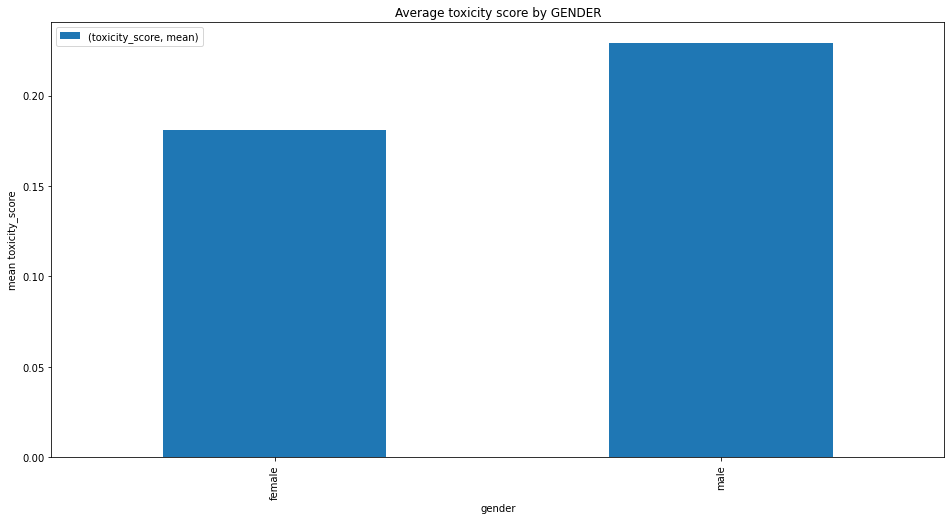

In [25]:
# Plot an aggregate visualization to answer the exploratory question
df_toxicity_new_final[['gender', 'toxicity_score']].groupby('gender').agg(['mean']).plot.bar()
fig = plt.gcf()
fig.set_size_inches(16, 8)
plt.title("Average toxicity score by GENDER")
plt.xlabel('gender')
plt.ylabel('mean toxicity_score')
plt.legend(loc=2)

# Save the plot into a JPG picture file. The file will be saved in the same working directory of my Jupyter notebook.
# The path location will be different on your machine. Feel free to update the directory to your choice.
plt.savefig('A2_chart_gender-toxicity_score.jpg', bbox_inches='tight', dpi=80)

plt.show()

**Evaluate: Age group + Toxicity Score**

Generate a pivot table between data fields and broken down age group into the toxicity score range

In [26]:
# Transform the data into pivot table format for detail analysis
toxicity_tab_age_group = pd.crosstab(df_toxicity_new_final['age_group'], 
                                     columns = df_toxicity_new_final['toxicity_score'])
toxicity_tab_age_group

toxicity_score,-2,-1,0,1,2
age_group,,,,,
18-30,18685,81291,360289,238693,9224
30-45,12585,57412,213059,178158,7241
45-60,3266,13879,44957,39052,1973
Over 60,226,1299,4837,3270,85
Under 18,589,2735,13811,9987,680


In [27]:
# Viewing details from total distribution by toxicity score bucket
toxicity_tab_age_group / toxicity_tab_age_group.sum()

toxicity_score,-2,-1,0,1,2
age_group,,,,,
18-30,0.528556,0.519047,0.565645,0.508767,0.480342
30-45,0.356001,0.366578,0.334497,0.379738,0.377076
45-60,0.092388,0.088618,0.070581,0.083238,0.102744
Over 60,0.006393,0.008294,0.007594,0.006970,0.004426
Under 18,0.016661,0.017463,0.021683,0.021287,0.035411


*Comment 10: the result is consistent with what we expected from earlier analysis. Ages between 18 and 45 hold around **88%** in general and is fairly consistent among toxicity score buckets.* 

*This disproportion of the population creates **BIAS** in the overall dataset.* 

*- Older people (over 60) with more experience in life will have a different judgement on toxic comment.*

*- Younger people (under 18) as teenager with less experience in life will also have a different judgement on toxic comment.*

*- Middle people (18 - 60) will also have a different judgement on toxic comment.*

Visualize this findings by plotting a chart below

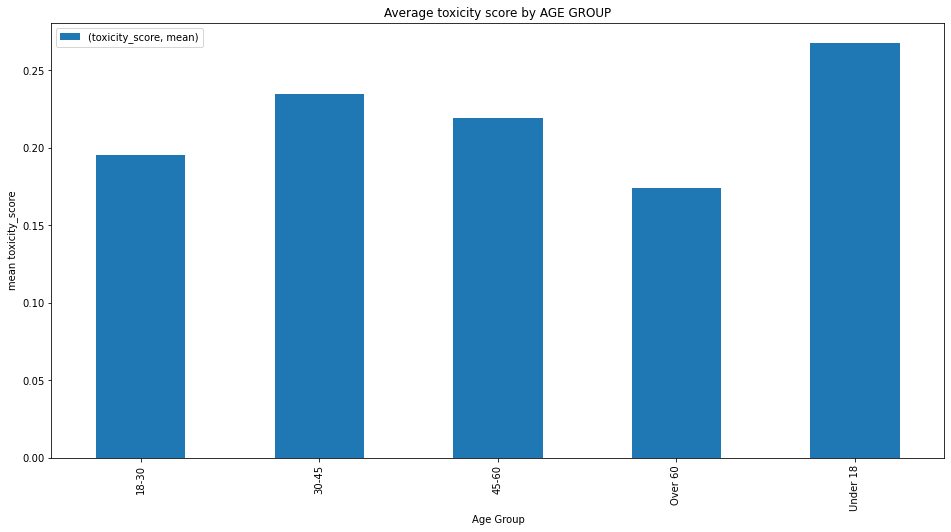

In [28]:
df_toxicity_new_final[['age_group', 'toxicity_score']].groupby('age_group').agg(['mean']).plot.bar()
fig = plt.gcf()
fig.set_size_inches(16, 8)
plt.title("Average toxicity score by AGE GROUP")
plt.xlabel('Age Group')
plt.ylabel('mean toxicity_score')
plt.legend(loc=2)

# Save the plot into a JPG picture file. The file will be saved in the same working directory of my Jupyter notebook.
# The path location will be different on your machine. Feel free to update the directory to your choice.
plt.savefig('A2_chart_age_group-toxicity_score.jpg', bbox_inches='tight', dpi=80)

plt.show()

Let's go one step further by incorporate one more dimension into the visualization to make it a multivariate chart. 

3D = 3 dimensional variables (age group + toxicity score + education)

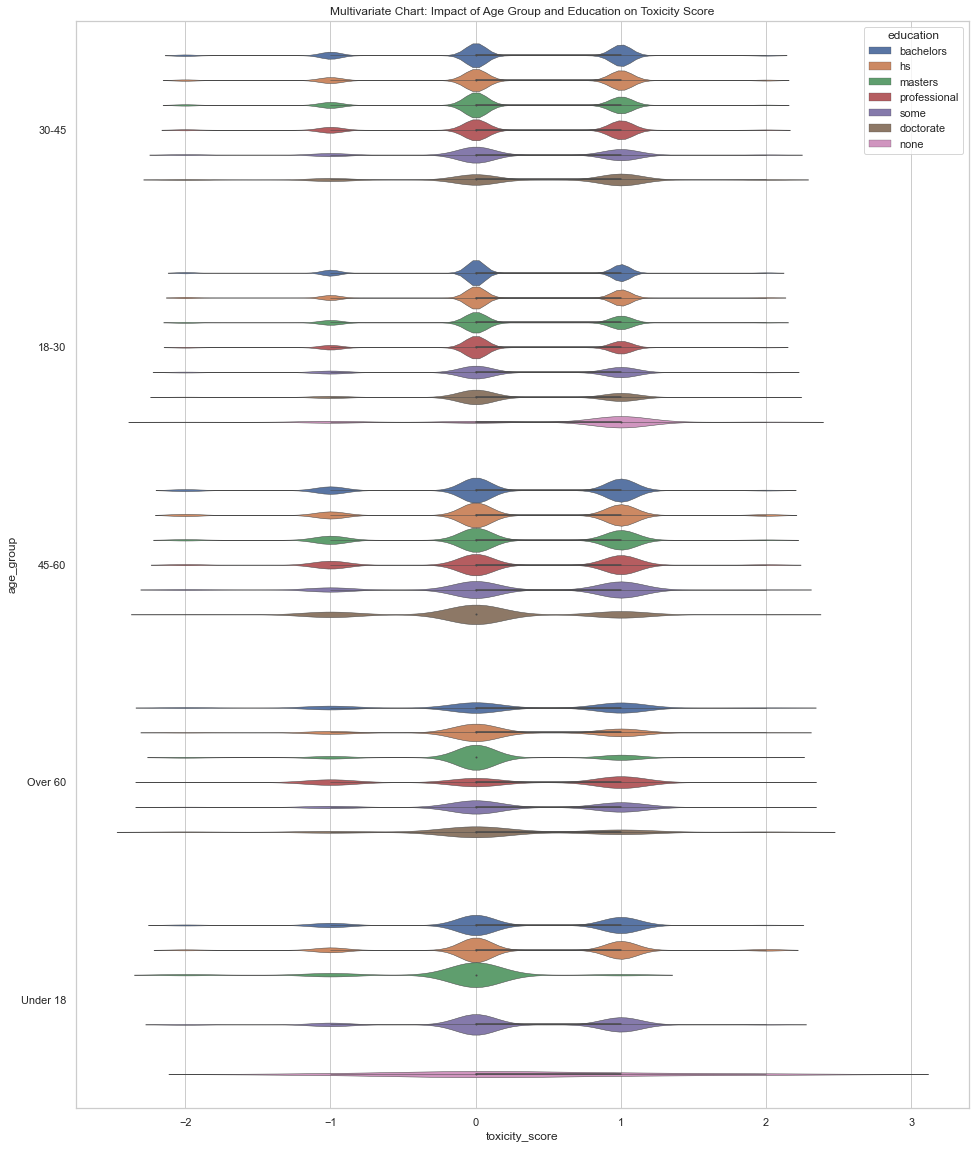

In [31]:
fig = plt.gcf()
fig.set_size_inches(16, 20)

sn.set(style="whitegrid")

### Violin plot
sn.violinplot(df_toxicity_new_final['toxicity_score'],
              df_toxicity_new_final['age_group'], 
               hue = df_toxicity_new_final['education'],
               shade = True,
               linewidth = 0.5);

plt.title('Multivariate Chart: Impact of Age Group and Education on Toxicity Score')

# Save the plot into a JPG picture file. The file will be saved in the same working directory of my Jupyter notebook.
# The path location will be different on your machine. Feel free to update the directory to your choice.
plt.savefig('A2_chart_age_group-toxicity_score-education.jpg', bbox_inches='tight', dpi=80)

*Comment 11: With only two dimension variable (age group, toxicity score), we wonder why under 18 has a high average toxicity score than other age group from previous chart.*

*Now with 3D chart (age group, toxicity score, education), we see the reason of why and the **BIAS** it produces. This violin chart reveals a missing "professional" and "none" education background data point. This bolsten the **BIAS** finding in labeling toxic comment by age group from education background view*

**Evaluate: Education + Toxicity Score**

Generate a pivot table between data fields and broken down education into the toxicity score range

In [32]:
# Transform the data into pivot table format for detail analysis
toxicity_tab_education = pd.crosstab(df_toxicity_new_final['education'], 
                                     columns = df_toxicity_new_final['toxicity_score'])
toxicity_tab_education

toxicity_score,-2,-1,0,1,2
education,,,,,
bachelors,14400,64590,254559,188370,7285
doctorate,420,1443,6762,5200,308
hs,10864,42080,175846,135559,6931
masters,5077,24371,100976,67311,2255
none,9,113,123,655,25
professional,3528,20393,81862,59173,1818
some,1053,3626,16825,12892,581


In [33]:
# Viewing details from total distribution by toxicity score bucket
toxicity_tab_education / toxicity_tab_education.sum()

toxicity_score,-2,-1,0,1,2
education,,,,,
bachelors,0.407343,0.412410,0.399651,0.401505,0.379368
doctorate,0.011881,0.009214,0.010616,0.011084,0.016039
hs,0.307318,0.268683,0.276074,0.288940,0.360933
masters,0.143617,0.155610,0.158530,0.143471,0.117430
none,0.000255,0.000722,0.000193,0.001396,0.001302
professional,0.099799,0.130210,0.128521,0.126125,0.094673
some,0.029787,0.023152,0.026415,0.027479,0.030256


*Comment 12: from a high level, the higher education (bachelors, masters, doctorate) holds more than **56%** and is consistent when comparing among the toxicity score bucket (very toxic, neutral, very healthy)*

*Another insight to point out that worker with no education background even though accounts a small percentage in total but it has higher toxicity score toward slightly healthy comments based on ratio proportion.*

Visualize this findings by plotting a chart below

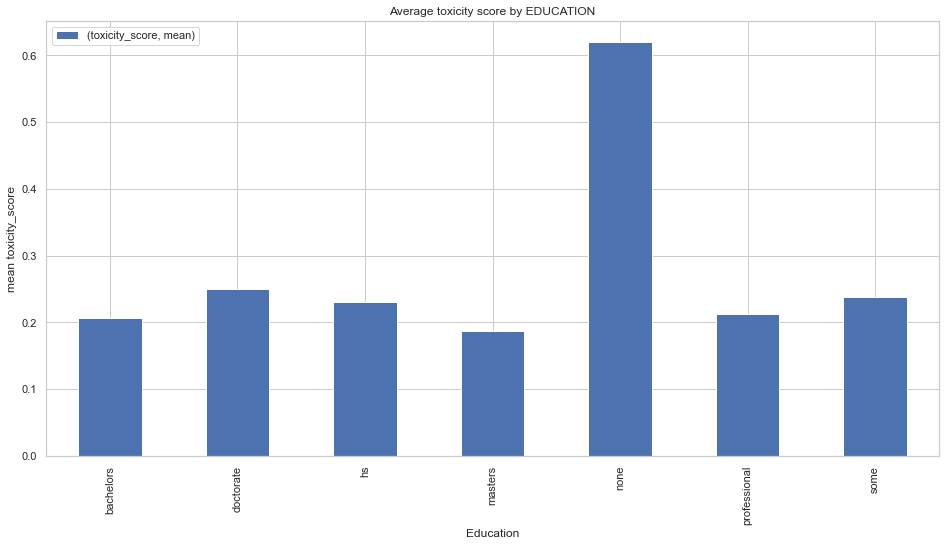

In [34]:
# Plot an aggregate visualization to answer the exploratory question
df_toxicity_new_final[['education', 'toxicity_score']].groupby('education').agg(['mean']).plot.bar()
fig = plt.gcf()
fig.set_size_inches(16, 8)
plt.title("Average toxicity score by EDUCATION")
plt.xlabel('Education')
plt.ylabel('mean toxicity_score')
plt.legend(loc=2)

# Save the plot into a JPG picture file. The file will be saved in the same working directory of my Jupyter notebook.
# The path location will be different on your machine. Feel free to update the directory to your choice.
plt.savefig('A2_chart_education-toxicity_score.jpg', bbox_inches='tight', dpi=80)

plt.show()

Let's go one step further by incorporate one more dimension into the visualization to make it a multivariate chart. 

3D = 3 dimensional variables (education + toxicity score + gender)

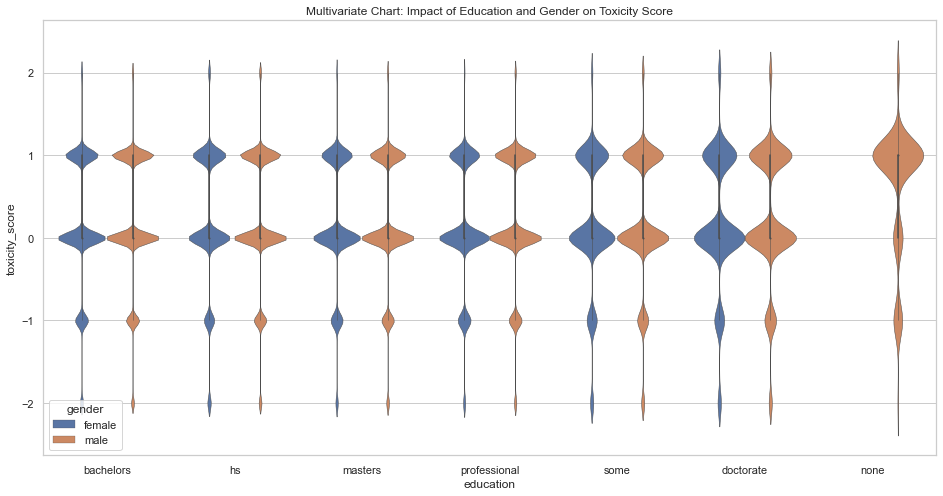

In [35]:
fig = plt.gcf()
fig.set_size_inches(16, 8)

sn.set(style="whitegrid")

### Violin plot
sn.violinplot(df_toxicity_new_final['education'], 
               df_toxicity_new_final['toxicity_score'],
               hue = df_toxicity_new_final['gender'],
               shade = True,
               linewidth = 0.5);

plt.title('Multivariate Chart: Impact of Education and Gender on Toxicity Score')

# Save the plot into a JPG picture file. The file will be saved in the same working directory of my Jupyter notebook.
# The path location will be different on your machine. Feel free to update the directory to your choice.
plt.savefig('A2_chart_education-toxicity_score-gender.jpg', bbox_inches='tight', dpi=80)

*Comment 13: With only two dimension variable (education, toxicity score), we wonder why no education background (none) is unique from the previous chart.*

*Now with 3D chart (education, toxicity score, gender), we see the reason of why and the **BIAS** it produces*

*- As previously found, male workers as annotators are more than female workers. This not gender-balanced is a point 1*

*- This violin chart reveals a missing female workers data point with no education background. This is another point 2*

*These 2 points together present another **BIAS** in labeling toxic comment by gender from education background view*

## Analysis: Agression Dataset

### Get Data & Clean Up

Get Aggression data files into data frames. For code simplification, we use annotation as follow:

- ann = annotations
- com = annotated comments
- dem = worker demographics

In [36]:
df_aggression_ann = pd.read_csv('aggression_annotations.tsv', sep = '\t')

df_aggression_com = pd.read_csv('aggression_annotated_comments.tsv', sep = '\t')

df_aggression_dem = pd.read_csv('aggression_worker_demographics.tsv', sep = '\t')

Perform visual inspection on the data

In [37]:
df_aggression_ann.head()

,rev_id,worker_id,aggression,aggression_score
0,37675,1362,1.0,-1.0
1,37675,2408,0.0,1.0
2,37675,1493,0.0,0.0
3,37675,1439,0.0,0.0
4,37675,170,0.0,0.0


In [38]:
df_aggression_com.head()

,rev_id,comment,year,logged_in,ns,sample,split
0,37675,`-NEWLINE_TOKENThis is not ``creative``. Thos...,2002,True,article,random,train
1,44816,`NEWLINE_TOKENNEWLINE_TOKEN:: the term ``stand...,2002,True,article,random,train
2,49851,"NEWLINE_TOKENNEWLINE_TOKENTrue or false, the s...",2002,True,article,random,train
3,89320,"Next, maybe you could work on being less cond...",2002,True,article,random,dev
4,93890,This page will need disambiguation.,2002,True,article,random,train


In [39]:
df_aggression_dem.head()

,worker_id,gender,english_first_language,age_group,education
0,833,female,0,45-60,bachelors
1,1072,male,0,30-45,bachelors
2,872,male,0,18-30,hs
3,2116,male,0,30-45,professional
4,453,male,0,30-45,hs


From observation, we see there are some data format we need to do in order to have a clean data.

In [40]:
# Reformat the numeric values to remove the ".0"
df_aggression_ann = df_aggression_ann.astype(int)

# remove newline and tab tokens
df_aggression_com['comment'] = df_aggression_com['comment'].apply(lambda x: x.replace("NEWLINE_TOKEN", " "))
df_aggression_com['comment'] = df_aggression_com['comment'].apply(lambda x: x.replace("TAB_TOKEN", " "))

### Descriptive Statistics Checking

Checking total of unique records of three data files

In [41]:
# Checking total of unique records
print("Total annotations: ", len(df_aggression_ann['rev_id'].unique()))
print("Total annotated comments: ", len(df_aggression_com['rev_id'].unique()))
print("Total workers: ", len(df_aggression_dem['worker_id'].unique()))

Total annotations:  115864
Total annotated comments:  115864
Total workers:  2190


Since we are interested in question about demograpic, let's do a brief glance through key demographic data components

**Gender distribution**

In [42]:
# Distribution table
df_aggression_dem['gender'].value_counts()

male      1349
female     840
other        1
Name: gender, dtype: int64

*Comment 14: There is one worker does not identify as either male or female. This one "other" is not significant in a whole schema and is a noise. So we need to remove it from the data frame*

In [43]:
# Remove this one record for this unique worker
df_aggression_dem = df_aggression_dem.drop(df_aggression_dem[df_aggression_dem.gender == 'other'].index)

# Review the clean gender data
df_aggression_dem['gender'].value_counts()

male      1349
female     840
Name: gender, dtype: int64

Let's look at the frequency table

In [44]:
# Frequency table
x5 = df_aggression_dem['gender'].value_counts()
x5 / x5.sum()

male      0.616263
female    0.383737
Name: gender, dtype: float64

*Comment 15: There are about **1.5X** number of male workers than female workers. Male workers account **61.6%**. This means the gender is not balanced among the workers. This factor shows a **BIAS** in annotating the toxicity comment because men and women have different perspective about aggression*

**English first language distribution**

In [45]:
# Distribution table
df_aggression_dem['english_first_language'].value_counts()

0    1787
1     402
Name: english_first_language, dtype: int64

Let's look at the frequecy table

In [46]:
# Frequency table
x6 = df_aggression_dem['english_first_language'].value_counts()
x6 / x6.sum()

0    0.816354
1    0.183646
Name: english_first_language, dtype: float64

*Comment 16: The number of workers that don't have English as first language is about **4.4X** time more than the workers with English as first language (accounts **81.6%**). This is an important notice to mention in the analysis, this can present a **BIAS** because it impacts the judgement of worker to label the English comment as aggression or not.*

**Age group distribution**

In [47]:
# Distribution table
df_aggression_dem['age_group'].value_counts()

18-30       1048
30-45        831
45-60        218
Under 18      37
Over 60       20
Name: age_group, dtype: int64

Let's look at the frequency table

In [48]:
# Frequency table
x7 = df_aggression_dem['age_group'].value_counts()
x7 / x7.sum()

18-30       0.486537
30-45       0.385794
45-60       0.101207
Under 18    0.017177
Over 60     0.009285
Name: age_group, dtype: float64

*Comment 17: The age distribution of the workers who labelled the aggression dataset shows that the vast majority of the data was labelled by people ages 18 - 45 which account **86%**. This is **BIAS** because the distribution is not equal across the age groups. We can see less representation for people who are older and younger than 45 and 18 respectively. Whether this is millenium generation, baby boom generation, generation X, etc. they each have different lived experiences which could affect their decision in what constitutes an aggression comment.*

**Education distribution**

In [49]:
# Distribution table
df_aggression_dem['education'].value_counts()

bachelors       861
hs              631
masters         385
professional    243
some             48
doctorate        20
none              1
Name: education, dtype: int64

Let's look at the frequency table

In [50]:
# Frequency table
x8 = df_aggression_dem['education'].value_counts()
x8 / x8.sum()

bachelors       0.393330
hs              0.288259
masters         0.175879
professional    0.111010
some            0.021928
doctorate       0.009137
none            0.000457
Name: education, dtype: float64

*Comment 18: We can see from the distribution that the higher education (bachelors + masters + doctorate = **57.8%**) which is more than half of the total worker education background. This is **BIAS** because different educstion background would impact the critical thinking and educational judgement on if the comment is aggression or not in this nature*

### MERGE DATA: demographic data + aggression data

Three separate data files are not helpful to unlock an insights. Therefore, we will merge all three data files into one final data frame. This will help us to see the relationship between data componnents

In [51]:
# Merge the data frame of aggression annotation and demographic worker
df_aggression_ann_dem = pd.merge(df_aggression_ann, df_aggression_dem, on = 'worker_id', how = 'outer')

# Merge the result with the comment data frame
df_aggression_final = pd.merge(df_aggression_ann_dem, df_aggression_com, on = 'rev_id', how = 'outer')

Viewing final data

In [52]:
df_aggression_final.head()

,rev_id,worker_id,aggression,aggression_score,gender,english_first_language,age_group,education,comment,year,logged_in,ns,sample,split
0,37675,1362,1,-1,male,0.0,18-30,masters,`- This is not ``creative``. Those are the di...,2002,True,article,random,train
1,37675,2408,0,1,male,1.0,30-45,hs,`- This is not ``creative``. Those are the di...,2002,True,article,random,train
2,37675,1493,0,0,female,0.0,30-45,bachelors,`- This is not ``creative``. Those are the di...,2002,True,article,random,train
3,37675,1439,0,0,male,0.0,18-30,hs,`- This is not ``creative``. Those are the di...,2002,True,article,random,train
4,37675,170,0,0,NaN,NaN,NaN,NaN,`- This is not ``creative``. Those are the di...,2002,True,article,random,train


From observation of dataset, there are some NaN values. Let's find out in the dataset about these NaN for these workers

In [53]:
# count the number of NaN value from the final dataset
aggression_count_NaN = df_aggression_final.isnull().sum()
aggression_count_NaN

rev_id                         0
worker_id                      0
aggression                     0
aggression_score               0
gender                    509786
english_first_language    509786
age_group                 521793
education                 509786
comment                        0
year                           0
logged_in                      0
ns                             0
sample                         0
split                          0
dtype: int64

*Comment 19: there are four places the NaN values show up in the merge dataset. Any data with NaN in the dataset won't be helpful and can create a distortion which impacts the data quality overall. We need to drop these NaN (not a number rows) from the data frame since it won't be helpful for the analysis.*

In [54]:
# Drop rows with NaN values from the final data frame
df_aggression_new_final = df_aggression_final.dropna()
df_aggression_new_final.head()

,rev_id,worker_id,aggression,aggression_score,gender,english_first_language,age_group,education,comment,year,logged_in,ns,sample,split
0,37675,1362,1,-1,male,0.0,18-30,masters,`- This is not ``creative``. Those are the di...,2002,True,article,random,train
1,37675,2408,0,1,male,1.0,30-45,hs,`- This is not ``creative``. Those are the di...,2002,True,article,random,train
2,37675,1493,0,0,female,0.0,30-45,bachelors,`- This is not ``creative``. Those are the di...,2002,True,article,random,train
3,37675,1439,0,0,male,0.0,18-30,hs,`- This is not ``creative``. Those are the di...,2002,True,article,random,train
5,37675,176,0,0,male,0.0,18-30,hs,`- This is not ``creative``. Those are the di...,2002,True,article,random,train


### EVALUATE: demographic data + aggression data

Let's check the kernel density plot of aggression score to see how it plays out

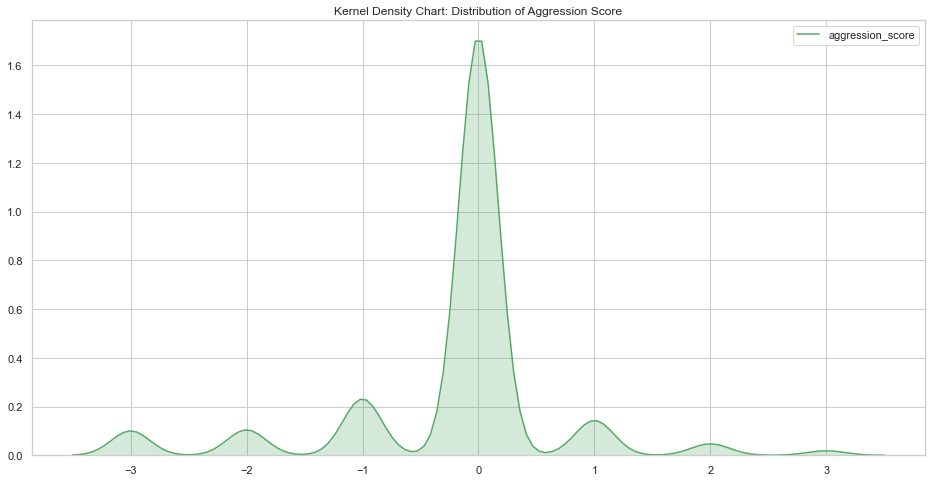

In [55]:
fig = plt.gcf()
fig.set_size_inches(16, 8)

# Kernel Density Plot
sn.kdeplot(df_aggression_new_final['aggression_score'], shade=True, color='g', 
           bw = 1/(np.max(df_aggression_new_final['aggression_score'])-np.min(df_aggression_new_final['aggression_score'])));

plt.title('Kernel Density Chart: Distribution of Aggression Score')

# Save the plot into a JPG picture file. The file will be saved in the same working directory of my Jupyter notebook.
# The path location will be different on your machine. Feel free to update the directory to your choice.
plt.savefig('A2_chart_aggression_score-kernel-density.jpg', bbox_inches='tight', dpi=80)

*Comment 20: Categorical variable ranging from very aggression (-3), to neutral (0), to very healthy (3)*

*From the kernel density plot, we see that majority of aggression score are **neutral (0)** comment.*

*However, in order to get deeper into the insights to see potential bias, we need to see aggression score with other data fields. Let's check the correlation to see if there are any useful information*

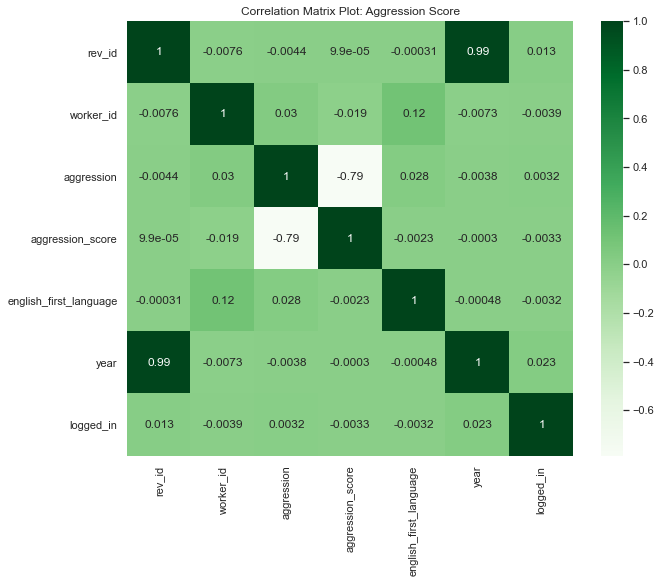

In [56]:
# Plot the correlation matrix
fig, ax = plt.subplots(figsize=(10,8))

corrMatrix_aggression = df_aggression_new_final.corr()

sn.heatmap(corrMatrix_aggression, annot=True, cmap="Greens")

plt.title("Correlation Matrix Plot: Aggression Score")

# Save the plot into a JPG picture file. The file will be saved in the same working directory of my Jupyter notebook.
# The path location will be different on your machine. Feel free to update the directory to your choice.
plt.savefig('A2_chart_aggression_score-correlation_matrix.jpg', bbox_inches='tight', dpi=80)

plt.show()

*Comment 21: From the correlation matrix, we can see there are not much correlation among the **numeric data fields** that impacts the aggression_score with more than 0.5*

*This helps us to narrow down the scope and focus on the **categorical data fields** for bias with the following data fields: gender, age group, and education*

**Evaluate: Gender + Aggression Score**

Generate a pivot table between data fields and broken down gender into the aggression score range

In [57]:
# Transform the data into pivot table format for detail analysis
aggression_tab_gender = pd.crosstab(df_aggression_new_final['gender'], 
                                    columns = df_aggression_new_final['aggression_score'])
aggression_tab_gender

aggression_score,-3,-2,-1,0,1,2,3
gender,,,,,,,
female,14206,13569,32451,223651,15303,4669,2129
male,21204,23456,50059,390821,35623,11960,4323


In [58]:
# Viewing details from total distribution by aggression score bucket
aggression_tab_gender / aggression_tab_gender.sum()

aggression_score,-3,-2,-1,0,1,2,3
gender,,,,,,,
female,0.401186,0.366482,0.393298,0.363973,0.300495,0.280775,0.329975
male,0.598814,0.633518,0.606702,0.636027,0.699505,0.719225,0.670025


*Comment 22: As we found out earlier, there is **BIAS** of gender-balanced among workers especially male. This influenced factor carries out to the aggression score outcome. On average, male workers are **65%** to show **BIAS** one way or the other (toxic, neutral, healthy)*

*The misrepresentation of worker population in labelling the comment is **BIAS** in this nature because different gender identity impacts the way people think and judge matters in life.*

Visualize this findings by plotting a chart below

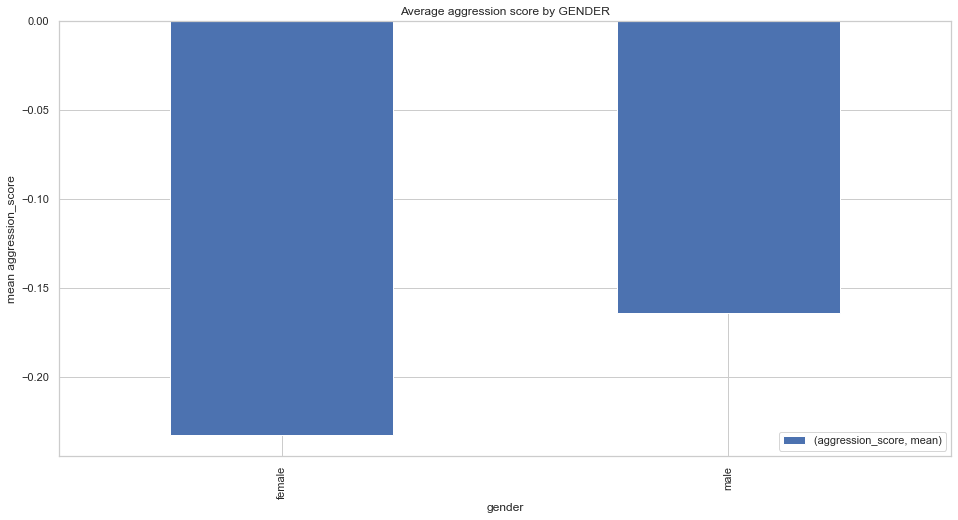

In [59]:
# Plot an aggregate visualization to answer the exploratory question
df_aggression_new_final[['gender', 'aggression_score']].groupby('gender').agg(['mean']).plot.bar()
fig = plt.gcf()
fig.set_size_inches(16, 8)
plt.title("Average aggression score by GENDER")
plt.xlabel('gender')
plt.ylabel('mean aggression_score')
plt.legend(loc=4)

# Save the plot into a JPG picture file. The file will be saved in the same working directory of my Jupyter notebook.
# The path location will be different on your machine. Feel free to update the directory to your choice.
plt.savefig('A2_chart_gender-aggression_score.jpg', bbox_inches='tight', dpi=80)

plt.show()

**Evaluate: Age group + Aggression Score**

Generate a pivot table between data fields and broken down age group into the aggression score range

In [60]:
# Transform the data into pivot table format for detail analysis
aggression_tab_age_group = pd.crosstab(df_aggression_new_final['age_group'], 
                                       columns = df_aggression_new_final['aggression_score'])
aggression_tab_age_group

aggression_score,-3,-2,-1,0,1,2,3
age_group,,,,,,,
18-30,16820,16174,32530,295606,20268,7276,2435
30-45,14051,16149,37873,254969,23796,7513,3233
45-60,3865,3826,10550,51976,5109,1369,618
Over 60,402,559,894,5002,579,314,91
Under 18,272,317,663,6919,1174,157,75


In [61]:
# Viewing details from total distribution by aggression score bucket
aggression_tab_age_group / aggression_tab_age_group.sum()

aggression_score,-3,-2,-1,0,1,2,3
age_group,,,,,,,
18-30,0.475007,0.436840,0.394255,0.481073,0.397989,0.437549,0.377402
30-45,0.396809,0.436165,0.459011,0.414940,0.467266,0.451801,0.501085
45-60,0.109150,0.103336,0.127863,0.084586,0.100322,0.082326,0.095784
Over 60,0.011353,0.015098,0.010835,0.008140,0.011369,0.018883,0.014104
Under 18,0.007681,0.008562,0.008035,0.011260,0.023053,0.009441,0.011624


*Comment 23: the result is consistent with what we expected from earlier analysis. Ages between 18 and 45 hold around **86%** in general and is fairly consistent among aggression score buckets*

*This disproportion of the population creates **BIAS** in the overall dataset*

*- Older people (over 60) with more experience in life will have a different judgement on toxic comment.*

*- Younger people (under 18) as teenager with less experience in life will also have a different judgement on toxic comment.*

*- Middle people (18 - 60) will also have a different judgement on toxic comment.*

Visualize this findings by plotting a chart below

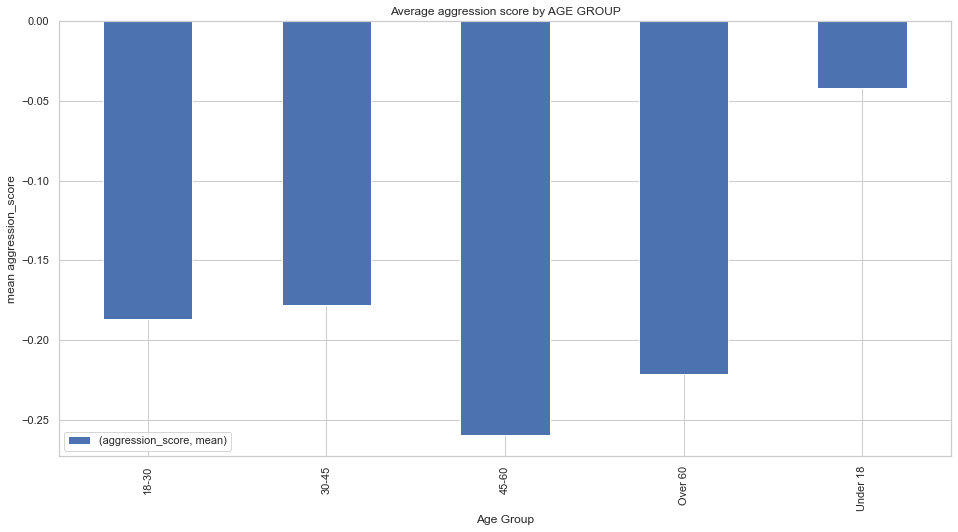

In [62]:
df_aggression_new_final[['age_group', 'aggression_score']].groupby('age_group').agg(['mean']).plot.bar()
fig = plt.gcf()
fig.set_size_inches(16, 8)
plt.title("Average aggression score by AGE GROUP")
plt.xlabel('Age Group')
plt.ylabel('mean aggression_score')
plt.legend(loc=3)

# Save the plot into a JPG picture file. The file will be saved in the same working directory of my Jupyter notebook.
# The path location will be different on your machine. Feel free to update the directory to your choice.
plt.savefig('A2_chart_age_group-aggression_score.jpg', bbox_inches='tight', dpi=80)

plt.show()

Let's go one step further by incorporate one more dimension into the visualization to make it multivariate chart.

3D = 3 dimensional variables (age group + aggression score + education)

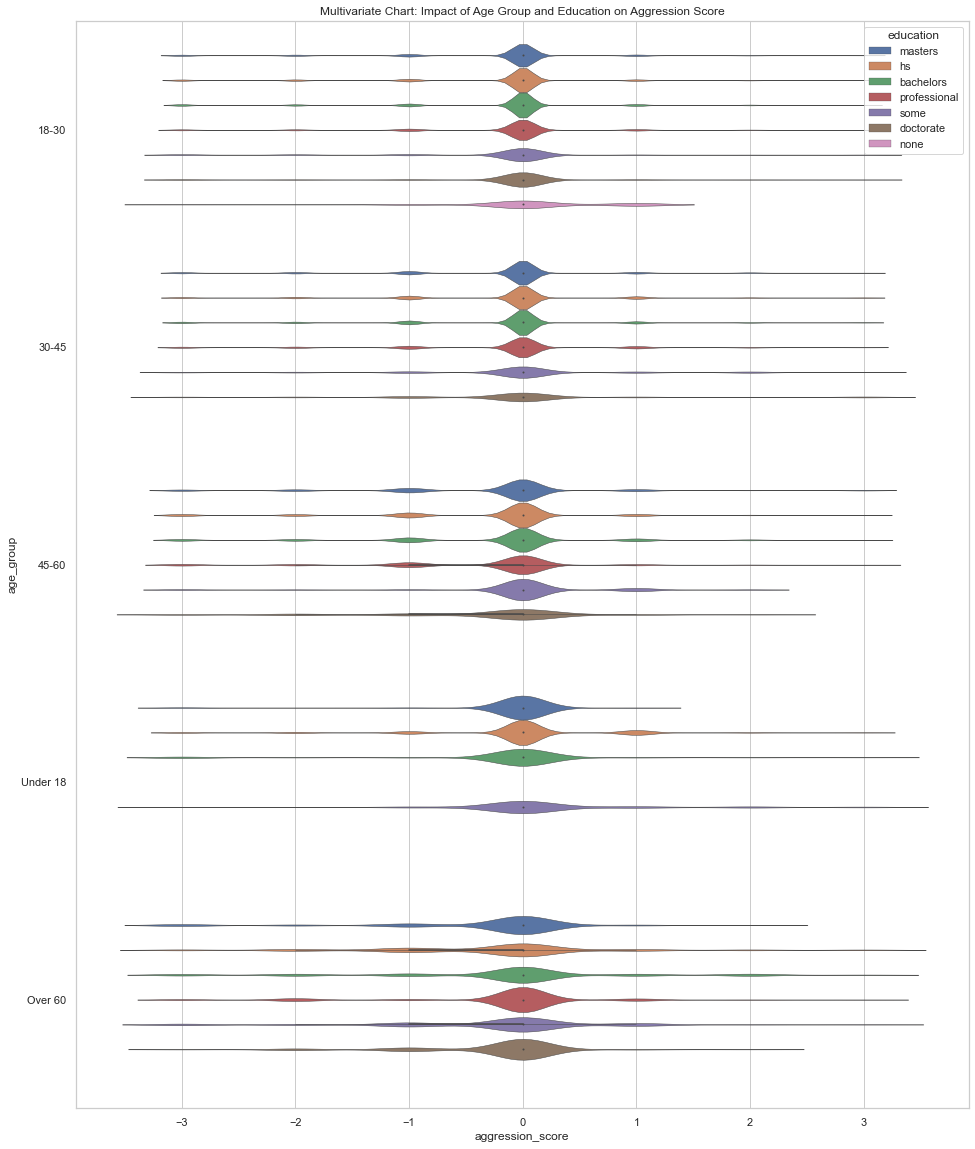

In [64]:
fig = plt.gcf()
fig.set_size_inches(16, 20)

sn.set(style="whitegrid")

### Violin plot
sn.violinplot(df_aggression_new_final['aggression_score'],
              df_aggression_new_final['age_group'], 
               hue = df_aggression_new_final['education'],
               shade = True,
               linewidth = 0.5);

plt.title('Multivariate Chart: Impact of Age Group and Education on Aggression Score')

# Save the plot into a JPG picture file. The file will be saved in the same working directory of my Jupyter notebook.
# The path location will be different on your machine. Feel free to update the directory to your choice.
plt.savefig('A2_chart_age_group-aggression_score-education.jpg', bbox_inches='tight', dpi=80)

*Comment 24: With only two dimension variables (age group, aggression score), we wonder why under 18 stood out from the rest of the other age group from the previous chart.*

*Now with 3D chart (age group, aggression score, education), we see the reason of why and the **BIAS** it produces. This violin chart reveals a missing "professional" and "doctorate" education background data point. This bolsten the **BIAS** finding in labeling aggression comment by age group from education background view*

**Evaluate: Education + Aggression Score**

Generate a pivot table between data fields and broken down education into the aggression score range

In [65]:
# Transform the data into pivot table format for detail analysis
aggression_tab_education = pd.crosstab(df_aggression_new_final['education'], 
                                       columns = df_aggression_new_final['aggression_score'])
aggression_tab_education

aggression_score,-3,-2,-1,0,1,2,3
education,,,,,,,
bachelors,15355,14480,32718,249853,20687,7479,2633
doctorate,349,380,783,5216,391,173,321
hs,9116,10486,23505,170274,14644,3877,2033
masters,6038,6758,14698,110800,7852,2671,764
none,1,0,7,64,23,0,0
professional,3778,4196,9464,66556,6357,1853,472
some,773,725,1335,11709,972,576,229


In [66]:
# Viewing details from total distribution by aggression score bucket
aggression_tab_education / aggression_tab_education.sum()

aggression_score,-3,-2,-1,0,1,2,3
education,,,,,,,
bachelors,0.433635,0.391087,0.396534,0.406614,0.406217,0.449756,0.408091
doctorate,0.009856,0.010263,0.009490,0.008489,0.007678,0.010404,0.049752
hs,0.257441,0.283214,0.284875,0.277106,0.287554,0.233147,0.315096
masters,0.170517,0.182525,0.178136,0.180317,0.154185,0.160623,0.118413
none,0.000028,0.000000,0.000085,0.000104,0.000452,0.000000,0.000000
professional,0.106693,0.113329,0.114701,0.108314,0.124828,0.111432,0.073156
some,0.021830,0.019581,0.016180,0.019055,0.019087,0.034638,0.035493


*Comment 25: from a high level, the higher education (bachelors, masters, doctorate) holds more than **57.8%** and is consistent when comparing among the toxicity score bucket (very toxic, neutral, very healthy)*

*Another insight to point out that worker with no education background even though accounts a small percentage in total but it has higher toxicity score toward slightly healthy comments based on ratio proportion.*

Visualize this findings by plotting a chart below

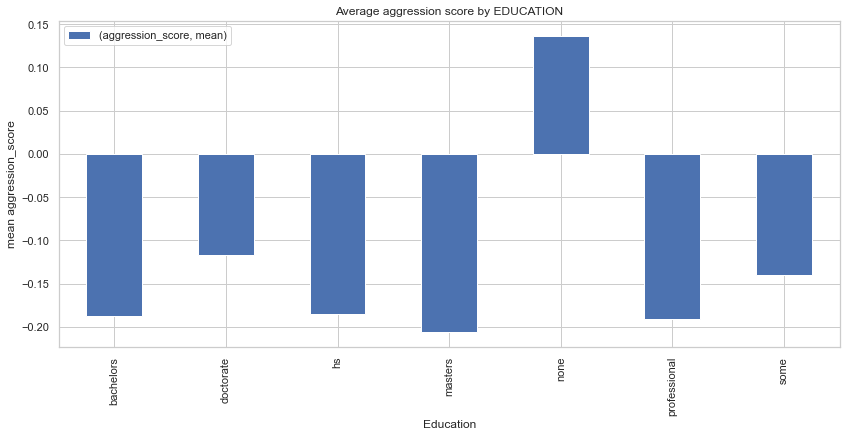

In [67]:
# Plot an aggregate visualization to answer the exploratory question
df_aggression_new_final[['education', 'aggression_score']].groupby('education').agg(['mean']).plot.bar()
fig = plt.gcf()
fig.set_size_inches(14, 6)
plt.title("Average aggression score by EDUCATION")
plt.xlabel('Education')
plt.ylabel('mean aggression_score')
plt.legend(loc=2)

# Save the plot into a JPG picture file. The file will be saved in the same working directory of my Jupyter notebook.
# The path location will be different on your machine. Feel free to update the directory to your choice.
plt.savefig('A2_chart_education-aggression_score.jpg', bbox_inches='tight', dpi=80)

plt.show()

Let's go one step further by incorporate one more dimension into the visualization to make it multivariate chart.

3D = 3 dimensional variables (education + aggression score + gender)

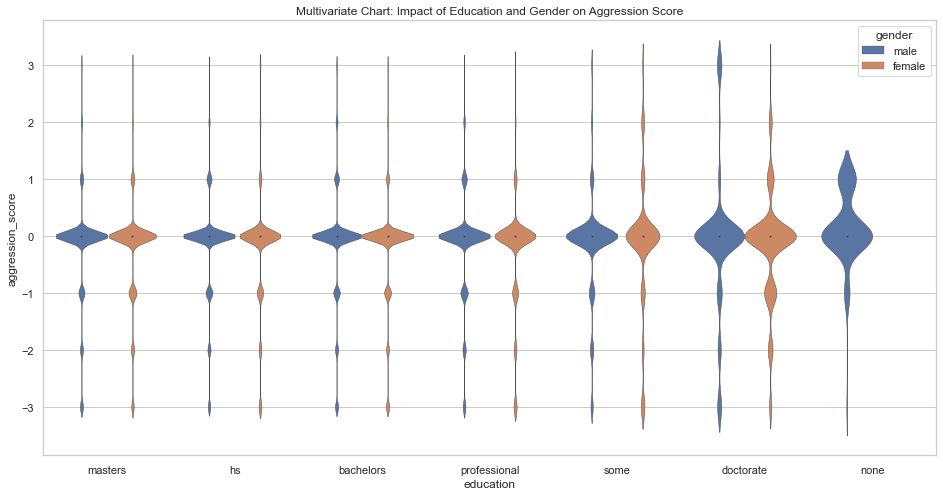

In [68]:
fig = plt.gcf()
fig.set_size_inches(16, 8)

sn.set(style="whitegrid")

### Violin plot
sn.violinplot(df_aggression_new_final['education'], 
               df_aggression_new_final['aggression_score'],
               hue = df_aggression_new_final['gender'],
               shade = True,
               linewidth = 0.5);
plt.title('Multivariate Chart: Impact of Education and Gender on Aggression Score')

# Save the plot into a JPG picture file. The file will be saved in the same working directory of my Jupyter notebook.
# The path location will be different on your machine. Feel free to update the directory to your choice.
plt.savefig('A2_chart_education-aggression_score-gender.jpg', bbox_inches='tight', dpi=80)

*Comment 26: With only two dimension variables (education, aggression score), we wonder why no education background (none) is unique from the previous chart.*

*Now with 3D chart (education, aggression score, gender), we see the reason of why and the **BIAS** it produces*

*- As previous found, male workers as annotators are more than female workers. This not gender-balanced is a point 1*

*- This violin chart reveals a missing female workers data point with no education background. This is another point 2*

*These 2 points together present another **BIAS** in labelling aggression comment by gender from education background view*

# Part 2: Results

### TOXICITY Analysis

**WHAT DID YOU FIND?**

Throughout the EDA journey, i find out the answer for my question: **Is there a bias relationships between worker demographics and labeling behavior in toxicity? The answer is YES.**

Many worker demographic data components play an important role in annotating (labeling) toxicity comments not only by themself but also when merging with toxicity score dataset.

------

**DID YOU FIND BIAS?**

There are bias in making the judgement about toxicity comments from the following data fields:
- Gender
- English as First Language
- Age Group
- Education

These biases are noted in my comments from the code.

------

**DID YOU NOT?**

For toxicity annotated comment data file (included actual real comment in text), I plan to use the word cloud and natural language processing (NLP) for analysis, but i saw some comments, especially words, are not approriate to show or display in the results and visualization. I decided not to perform an in-deep analysis on the comments.

To me, it is better to leave these sensitive words out of the analysis. That is my judgement call to ensure we have a clean and productive results, and most importantly, respect the research ethical norms.

---------

### AGGRESSION Analysis

**WHAT DID YOU FIND?**

Throughout the EDA journey, i find out the answer for my question: **Is there a bias relationships between worker demographics and labeling behavior in aggression? The answer is YES.**

Many worker demographic data components play an important role in annotating (labeling) aggression comments not only by themself but also when merging with aggression score dataset.

-----

**DID YOU FIND BIAS?**

There are bias in making the judgement about aggresssion comments from the following data fields:
- Gender
- English as First Language
- Age Group
- Education

These biases are noted in my comments from the code.

------

**DID YOU NOT?**

For aggression annotated comment data file (included actual real comment in text), I plan to use the word cloud and natural language processing (NLP) for analysis, but i saw some comments, especially words, are not approriate to show or display in the results and visualization. I decided not to perform an in-deep analysis on the comments.

To me, it is better to leave these sensitive words out of the analysis. That is my judgement call to ensure we have a clean and productive results, and most importantly, respect the research ethical norms.

# Part 3: Implications for research and product development

Below are some of my thoughts for further implications about bias after reviewing the Perspective Hacks application demo

**Link to Perspective Hacks**
https://github.com/conversationai/perspectiveapi/wiki/perspective-hacks


**Questions 1:** *Which, if any, of these demo applications would you expect the Perspective API to perform poorly in? Why?*

The application name "Comment Slider" is developed with the intend to sort the comment stream based on the toxicity score of each comment. 

I expect this application to perform poorly in sorting the comment on Twitter stream. There are a couple of reasons:
1. The activity - Twitter comment - it is supposed to support is dynamic and complex. On top of that, there are a limit on how many characters in each tweet and the creation of new communication sign everyday. Another scenario is mixing characters from multiple languages in one tweet. These factors impact the sorting comment based on the toxicity score of the application performance.


2. As we learn earlier from the above toxicity analysis, we see demographic characteristics present bias in toxicity labelling activity. There will be bias in the demographic twitter users. Each people will have his or her own political background, education, background, age group, income salary, etc. These demographic information traits are not available on the Twitter stream and based on the user privacy sharing setting of their profiles. Therefore, it will be a challenge for the application "Comment Slider" to sort comments for toxicity score. 

**Question 2:** *What are some kinds of hostile speech that would be difficult to accurately detect using the approach used to train the Perspective API models?*

A recent presidental debate is a good example. The "Comment Filter" application is created with intent to empower readers to choose what level of toxicity they want to read on different news sites using a Chrome extension. I expect it will be tough for this application to examine the debate in this scenario

One of the challenges is the speaking over each other or interrupting each other on the stage. As a human being, we struggle to understand the content in this chaos environment. How can we expect the "Comment Filter" to identify the spoken words from the hostile speech in order to be effecive in this scenario. It will be difficult to train the model in this nature.

**Question 3:** *Imagine you are one of the Google data scientists who maintains the Perspective API. If you wanted to improve the model or the API itself to make it work better for any of these purposes, how should they go about doing that?*

There are couple of things i would do:
1. Another important aspect of bias is unconsious bias. This unconsious bias becomes increasingly discussed recently. Can this machine learning model handle the unconsious bias from the comments as well as from the crown-worker? That is where we need to build a good dataset focusing on unconsious bias to feed into the current model. This is the project i will take on to improve the model API. 


2. Human knowledge is important in machine learning. Diverse opinions and unique experience bring the good outcome for any employer. How about we implement this Diversity & Inclusion in Perspective API? By including people from many education background, many cultural difference, country of origin, etc working on the same Perspective API project; we can use these various knowledge and experiences to build a robust machine learning model. In returns, we have a better model to recognize bias. I would advocate to the hiring manager on this proposal for hiring diverse people.


3. Finally, most of the current Perspective API tools are for Google Chrome extension only. I would love to improve these API tools by making them available on other browsers such as Microsoft Internet Explore and Apple Safari. The more diverse users we have, the more feedbacks and data we get back to train the model.  